## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER Configuration #
######################
# A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    print(x_ellipse.shape)
    xvals = np.hstack((x_ellipse, np.zeros((N, 1))))
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()

spatial_domain = dde.geometry.Ellipse_A(eps, kappa, delta) 

x,u = gen_traindata(1001)
#x_domain = spatial_domain.random_points(1001)
#x = np.concatenate((x, x_domain))

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_domain = spatial_domain.random_points(n_test)
x_test = np.concatenate((x_test, x_domain))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))
print(x.shape, u.shape, x_test.shape, u_test.shape)

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

# observe_x = np.asarray([[1 + eps, 0], 
#                         [1 - eps, 0], 
#                         [1 - delta * eps, kappa * eps],
#                         [1 - delta * eps, -kappa * eps]]
#                     )
# observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

# observe_x = np.concatenate((x,observe_x))
# observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(x,u)
# bc135 = dde.PointSetBC(observe_x, observe_y)

# x[0] = R, x[1] = Z, u[0] = U
bc2 = dde.OperatorBC(spatial_domain ,
                    lambda x, u, _: psi_zz(x, u)+ N1*psi_r(x,u), 
                    boundary_outer)

bc4 = dde.OperatorBC(spatial_domain,
                    lambda x, u, _: psi_zz(x, u)+ N2*psi_r(x,u), 
                    boundary_inner)

bc6 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_r(x, u), boundary_high)
bc7 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_rr(x, u)+ N3 * psi_z(x, u), boundary_high)

print(x_test.shape, x.shape)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    #anchors=observe_x,
    num_domain=1024,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="LHS"
)

# net = dde.maps.FNN([3] + 4 * [40] + [1], "tanh", "Glorot normal")

# model = dde.Model(data, net)


Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
(1001, 2)
(100, 2)
(1001, 3) (1001, 1) (200, 3) (200, 1)
(200, 3) (1001, 3)


Text(0, 0.5, '$u(r,z=0)$')

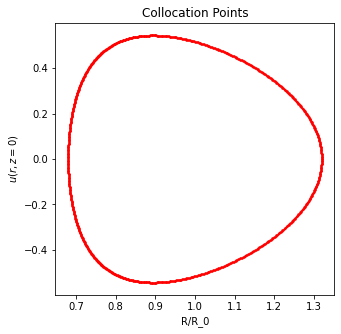

In [2]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [3]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)

## Train Model

Compiling model...
Building feed-forward neural network...


/Users/alankaptanoglu/deepxde_copy/deepxde/maps/fnn.py:112: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'build' took 0.267098 s

'compile' took 3.383037 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.03e+00, 3.77e-01]    [1.13e+00, 0.00e+00]    []  
1         [1.19e+00, 4.42e+00]    [1.28e+00, 0.00e+00]    []  
2         [1.08e+00, 4.79e-01]    [1.18e+00, 0.00e+00]    []  
3         [9.99e-01, 3.02e-01]    [1.09e+00, 0.00e+00]    []  
4         [9.58e-01, 1.09e+00]    [1.05e+00, 0.00e+00]    []  
5         [9.58e-01, 7.76e-01]    [1.05e+00, 0.00e+00]    []  
6         [9.74e-01, 1.81e-01]    [1.07e+00, 0.00e+00]    []  
7         [9.91e-01, 1.44e-02]    [1.08e+00, 0.00e+00]    []  
8         [9.97e-01, 2.65e-01]    [1.09e+00, 0.00e+00]    []  
9         [9.82e-01, 4.06e-01]    [1.07e+00, 0.00e+00]    []  
10        [9.52e-01, 2.66e-01]    [1.04e+00, 0.00e+00]    []  
11        [9.15e-01, 7.90e-02]    [1.01e+00, 0.00e+00]    []  
12        [8.77e-01, 2.05e-02]    [9.67e-01, 0.00e+00]    []  
13        [8.3

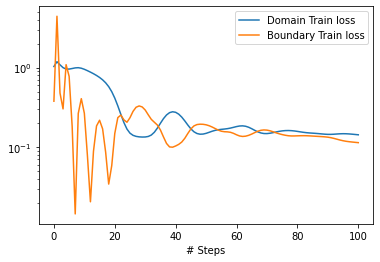

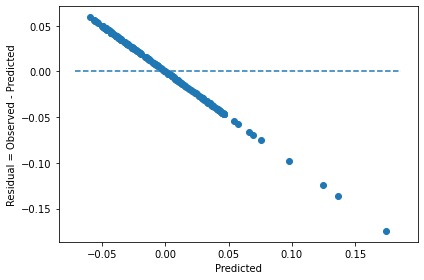

In [4]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 3
BREADTH = 20
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([3] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,100]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 1)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

# make mesh
# nx = 100
# ny = 100
# zoom = ((1 + eps)-(1 - eps))*0.05
# innerPoint = 1 - eps - zoom
# outerPoint = 1 + eps + zoom
# lowPoint   = -kappa * eps - zoom
# highPoint  = kappa * eps + zoom
# x, y = np.meshgrid(
#     np.linspace(innerPoint, outerPoint, nx),
#     np.linspace(lowPoint, highPoint, ny),
# )
# X = np.vstack((np.ravel(x), np.ravel(y))).T
# output = model.predict(X)
# GS = model.predict(X, operator=pde_solovev)
# residual_psi = np.mean(np.absolute(GS))

# print("Accuracy")
# print("Mean residual:", residual_psi)

#### After BFGS

Compiling model...
'compile' took 4.588841 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.43e-01, 1.14e-01]    [2.01e-01, 0.00e+00]    []  
110       [1.24e-01, 7.90e-02]                                
120       [3.89e-02, 2.99e-02]                                
130       [9.21e-03, 2.31e-02]                                
140       [8.57e-03, 7.77e-03]                                
150       [4.53e-03, 2.91e-03]                                
160       [1.58e-03, 2.43e-03]                                
170       [1.11e-03, 2.15e-03]                                
180       [9.69e-04, 1.83e-03]                                
190       [1.16e-03, 9.41e-04]                                
200       [1.03e-03, 6.33e-04]                                
210       [6.69e-04, 5.13e-04]                                
220       [5.14e-04, 4.09e-04]                                
230       [5.76e-04, 1.27e-04]                

1380      [5.10e-06, 5.36e-07]                                
1390      [4.98e-06, 5.92e-07]                                
1400      [4.63e-06, 6.25e-07]                                
1410      [4.50e-06, 6.16e-07]                                
1420      [4.28e-06, 6.88e-07]                                
1430      [4.09e-06, 6.47e-07]                                
1440      [3.89e-06, 6.94e-07]                                
1450      [3.79e-06, 6.44e-07]                                
1460      [3.77e-06, 6.16e-07]                                
1470      [3.76e-06, 6.04e-07]                                
1480      [3.73e-06, 6.13e-07]                                
1490      [3.71e-06, 6.10e-07]                                
1500      [3.69e-06, 6.09e-07]                                
1510      [3.46e-06, 5.41e-07]                                
1520      [3.37e-06, 4.74e-07]                                
1530      [3.15e-06, 4.94e-07]                         

2690      [1.32e-06, 3.79e-08]                                
2700      [1.31e-06, 3.88e-08]                                
2710      [1.44e-06, 1.20e-07]                                
2720      [1.28e-06, 4.23e-08]                                
2730      [1.26e-06, 4.46e-08]                                
2740      [1.26e-06, 3.82e-08]                                
2750      [1.23e-06, 4.46e-08]                                
2760      [1.23e-06, 3.90e-08]                                
2770      [1.22e-06, 3.67e-08]                                
2780      [1.22e-06, 3.13e-08]                                
2790      [1.23e-06, 2.93e-08]                                
2800      [1.22e-06, 3.19e-08]                                
2810      [1.22e-06, 3.03e-08]                                
2820      [1.22e-06, 2.92e-08]                                
2830      [1.22e-06, 3.01e-08]                                
2840      [1.22e-06, 2.93e-08]                         

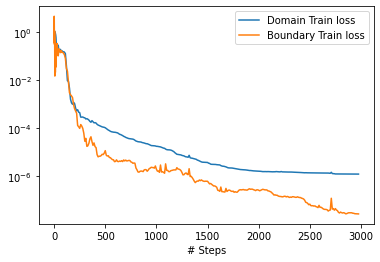

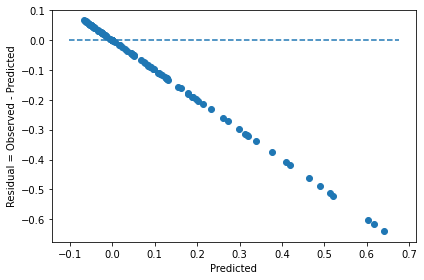

In [5]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


In [6]:
# Evaluation
from utils.utils import evaluate_A, relative_error_plot
ITER = GS_Linear(eps= 0.32, kappa=1.7, delta=0.33)
x,y,A,psi_pred,psi_true,error=evaluate_A(ITER,model)
X_test = spatial_domain.random_points(300)
psi_true_full = psi_true
psi_pred_full = psi_pred
x = x[:, :, 0]
y = y[:, :, 0]


TypeError: psi_func() takes 3 positional arguments but 4 were given

In [ ]:
# Plotting Setup
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom

psi_pred = psi_pred_full[:, :, 0]
psi_true = psi_true_full[:, :, 0]
print(psi_pred.shape)

fig,axs=plt.subplots(2,2,figsize=(10,10))
ax1,ax2,ax3,ax4=axs[0][0],axs[0][1],axs[1][0],axs[1][1]
levels = np.linspace(min(psi_true.reshape(-1)),0,8)

# Plot 1 - PINN Solution
cp = ax1.contour(x, y, psi_pred ) #,levels=levels)
# ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
fig.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
ax1.set_title('PINN Solution')
ax1.set_xlabel(r'$R/R_{0}$')
ax1.set_ylabel(r'$Z/R_{0}$')
ax1.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

# Plot 2 - Analytic Solution
cp = ax2.contour(x, y, psi_true ) #,levels=levels)
fig.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
ax2.set_title('Analytical Solution')
ax2.set_xlabel(r'$R/R_{0}$')
ax2.set_ylabel(r'$Z/R_{0}$')
ax2.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

# Plot 4 - Relative Error
cp = ax3.contour(x, y, error[:, :, 0],levels=levels)
#fig.colorbar(cp,ax=ax3).formatter.set_powerlimits((0, 0))
#ax2.set_title('Analytical Solution')
ax3.set_xlabel(r'$R/R_{0}$')
ax3.set_ylabel(r'$Z/R_{0}$')
ax3.axis(xmin=innerPoint,xmax=outerPoint,ymin=lowPoint, ymax=highPoint)

fig.tight_layout()
plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_after_BFGS.jpg')



In [ ]:
# Store Values
engineering_params = {
    "true_volume": 0.0,
    "pred_volume": 0.0,
    "true_Cp": 0.0,
    "pred_Cp": 0.0,
    "true_qstar": 0.0,
    "pred_qstar": 0.0,
    "true_beta_p": 0.0,
    "pred_beta_p": 0.0,
    "true_beta_t": 0.0,
    "pred_beta_t": 0.0,
    "true_beta": 0.0,
    "pred_beta": 0.0,
}

# Compute a contour integral
def area(vs):
    a = 0
    x0, y0 = vs[0]
    for [x1, y1] in vs[1:]:
        dx = x1 - x0
        dy = y1 - y0
        a += 0.5 * (y0 * dx - x0 * dy)
        x0 = x1
        y0 = y1
    return a

# Compute Volume from psi = 0 flux surface for true and predicted
c = plt.contour(x, y, psi_true, [0])
v = c.collections[0].get_paths()[0].vertices
print('True volume = ', area(v))
engineering_params["true_volume"] = area(v)

c = plt.contour(x, y, psi_pred, [0])
v = c.collections[0].get_paths()[0].vertices
print('predicted volume = ', area(v))
engineering_params["pred_volume"] = area(v)

def Cp(vs):
    a = 0
    x0, y0 = vs[0]
    for [x1, y1] in vs[1:]:
        dx = x1 - x0
        dy = y1 - y0
        dy_dx = dy / dx
        a += np.sqrt(1 + dy_dx ** 2) * abs(dx)
        x0 = x1
        y0 = y1
    return a

# Compute Cp from psi = 0 flux surface for true and predicted
c = plt.contour(x, y, psi_true, [0])
v = c.collections[0].get_paths()[0].vertices
print('True Cp = ', Cp(v))
engineering_params["true_Cp"] = Cp(v)

c = plt.contour(x, y, psi_pred, [0])
v = c.collections[0].get_paths()[0].vertices
print('predicted Cp = ', Cp(v))
engineering_params["pred_Cp"] = Cp(v)

# Using Green's theorem again
def qstar_integral(vs):
    a = 0
    x0, y0 = vs[0]
    for [x1, y1] in vs[1:]:
        dx = x1 - x0
        dy = y1 - y0
        M = - 1 / x1
        a += M * dy
        x0 = x1
        y0 = y1
    return a

# Compute qstar from psi = 0 flux surface for true and predicted
c = plt.contour(x, y, psi_true, [0])
v = c.collections[0].get_paths()[0].vertices
mu0 = 4 * np.pi * 10 ** (-7)
I = 15 * 10 ** 6
a = 2.0
R0 = 6.2
epsilon = 0.32
B0 = 5.3
psi0 = - mu0 * I * a / epsilon / (-0.155 * qstar_integral(v) + 1.115 * area(v))
qstar = - (a * R0 * B0 * Cp(v)) / (psi0 * (-0.155 * qstar_integral(v) + 1.115 * area(v)))
print('True qstar = ', qstar)
engineering_params["true_qstar"] = qstar

psi_average = np.trapz(np.trapz(psi_true * x[0, :], x[0, :], axis=0), y[:, 0])
beta_p = 2 * 1.155 * Cp(v) ** 2 * psi_average / (
    area(v) * (-0.155 * qstar_integral(v) + 1.115 * area(v)) ** 2
)
print('True beta_p = ', beta_p)
print('True beta_t = ', epsilon ** 2 * beta_p / qstar ** 2)
print('True beta = ', epsilon ** 2 * beta_p / (qstar ** 2 + epsilon ** 2))
engineering_params["true_beta_p"] = beta_p
engineering_params["true_beta_t"] = epsilon ** 2 * beta_p / qstar ** 2
engineering_params["true_beta"] = epsilon ** 2 * beta_p / (qstar ** 2 + epsilon ** 2)


c = plt.contour(x, y, psi_pred, [0])
v = c.collections[0].get_paths()[0].vertices
psi_average = np.trapz(np.trapz(psi_pred * x[0, :], x[0, :], axis=0), y[:, 0])
psi0 = - mu0 * I * a / epsilon / (-0.155 * qstar_integral(v) + 1.115 * area(v))
qstar = - (a * R0 * B0 * Cp(v)) / (psi0 * (-0.155 * qstar_integral(v) + 1.115 * area(v)))
print('Predicted qstar = ', qstar)
engineering_params["pred_qstar"] = qstar

beta_p = 2 * 1.155 * Cp(v) ** 2 * 0.018170271593863394 / (
    area(v) * (-0.155 * qstar_integral(v) + 1.115 * area(v)) ** 2
)
print('Predicted beta_p = ', beta_p)
print('Predicted beta_t = ', epsilon ** 2 * beta_p / qstar ** 2)
print('Predicted beta = ', epsilon ** 2 * beta_p / (qstar ** 2 + epsilon ** 2))
engineering_params["pred_beta_p"] = beta_p
engineering_params["pred_beta_t"] = epsilon ** 2 * beta_p / qstar ** 2
engineering_params["pred_beta"] = epsilon ** 2 * beta_p / (qstar ** 2 + epsilon ** 2)

